# EE519 — Lecture 9 (Linear Prediction / LPC) — Notebook 9.0
## Record WAVs + manual frame selection (time ranges → frame indices)

**Theme:** You record (or load) files, then YOU choose vowel/fricative/silence regions via time ranges and save to manifest.

---
### 🧭 In-class workflow
1. Read the short explanation above each code cell
2. Predict what you expect to see
3. Run
4. Save at least one key figure

### 🧯 Debugging quick panel (“If you see X, do Y”)
- **Module import error** → run the “Environment & imports” cell again; restart kernel if needed.
- **Audio playback is silent** → re-record closer to mic; ensure waveform peak is not near zero.
- **`frame_selections` missing** → go back to Notebook 9.0 and define time ranges / frames, then save to manifest.
- **LPC envelope looks too wiggly** → reduce order `p` (try 10–16).
- **LPC envelope looks too flat** → increase order `p` slightly or pick a steadier vowel region.
- **FFT vs LPC don’t “overlay”** → use the provided “normalize-to-peak” plot (shape comparison) cell.


### 🎯 Learning goals
- Record and save a **standard set** of WAV files for Lecture 9
- Visualize waveform + spectrogram
- Select vowel/fricative/silence regions **manually** (by time ranges or frame indices)
- Store selections in `manifest.json` so later notebooks are one-click run


## 0. Environment & imports (run this first)

This notebook uses:
- `numpy`, `matplotlib`
- `scipy` (signal + linalg)
- optional: `sounddevice` (recording)
- optional: `sklearn` (mini ML demo only)

If any import fails, the cell prints what to do next.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Core scipy imports (required)
try:
    import scipy.signal as sig
    import scipy.linalg as la
    import scipy.io.wavfile as wavfile
    SCIPY_OK = True
    print("scipy imports: ✅")
except Exception as e:
    SCIPY_OK = False
    print("scipy imports: ❌")
    print("Error:", e)

# Optional recording
try:
    import sounddevice as sd
    HAS_SD = True
    print("sounddevice: ✅ (recording enabled)")
except Exception as e:
    HAS_SD = False
    print("sounddevice: ❌ (recording disabled)")

from pathlib import Path
import json, os, time
from IPython.display import Audio, display


scipy imports: ✅
sounddevice: ✅ (recording enabled)


## 1. Project + manifest workflow (same spirit as Lectures 7/8)

We will use one project folder:
```
EE519_L9_Project/
  recordings/
  figures/
  features/
  cache/
  manifest.json
```

✅ You can re-run this cell any time safely.


In [2]:
PROJECT_DIR = Path("EE519_L9_Project")
REC_DIR = PROJECT_DIR / "recordings"
FIG_DIR = PROJECT_DIR / "figures"
FEAT_DIR = PROJECT_DIR / "features"
CACHE_DIR = PROJECT_DIR / "cache"

for d in [PROJECT_DIR, REC_DIR, FIG_DIR, FEAT_DIR, CACHE_DIR]:
    d.mkdir(parents=True, exist_ok=True)

MANIFEST_PATH = PROJECT_DIR / "manifest.json"

def load_manifest():
    if MANIFEST_PATH.exists():
        return json.loads(MANIFEST_PATH.read_text())
    return {"clips": [], "meta": {"created": time.time(), "course":"EE519", "lecture":9}}

def save_manifest(m):
    MANIFEST_PATH.write_text(json.dumps(m, indent=2))

manifest = load_manifest()
print("Manifest clips:", len(manifest["clips"]))
print("Project dir:", PROJECT_DIR.resolve())


Manifest clips: 0
Project dir: C:\Users\K\Documents\usc\ee519\ee519-lecture\lecture10\EE519_L9_Project


## 2. Utilities (audio I/O, framing, STFT, saving figures)

These helpers are used throughout Lecture 9 notebooks.


In [3]:
def read_wav(path):
    fs, x = wavfile.read(path)
    x = x.astype(np.float32)
    if x.ndim > 1:
        x = x.mean(axis=1)
    if np.max(np.abs(x)) > 1.5:
        x = x / 32768.0
    return fs, x

def peak_normalize(x, target=0.95):
    m = np.max(np.abs(x)) + 1e-12
    return x * (target / m)

def play_audio(x, fs, label=""):
    print(label, f"(fs={fs}, length={len(x)/fs:.2f}s)")
    display(Audio(x, rate=fs))

def savefig(name):
    out = FIG_DIR / name
    plt.savefig(out, dpi=180, bbox_inches="tight")
    print("Saved:", out)

def hann(N):
    return np.hanning(N).astype(np.float32)

def frame_signal(x, N, H):
    if len(x) < N:
        raise ValueError("Signal shorter than frame length N.")
    num = 1 + (len(x) - N) // H
    frames = np.stack([x[i*H:i*H+N] for i in range(num)], axis=0)
    return frames

def stft_scipy(x, fs, win_ms=25, hop_ms=10, nfft=None, window="hann"):
    N = int(win_ms * 1e-3 * fs)
    H = int(hop_ms * 1e-3 * fs)
    if nfft is None:
        nfft = 1 << int(np.ceil(np.log2(N)))
    f, t, Z = sig.stft(x, fs=fs, window=window, nperseg=N, noverlap=N-H, nfft=nfft, boundary=None, padded=False)
    return f, t, Z, N, H

def plot_spectrogram(Z, fs, title, fmax=8000):
    S = 20*np.log10(np.abs(Z)+1e-12)
    plt.figure(figsize=(10,4))
    plt.imshow(S, origin="lower", aspect="auto",
               extent=[0, Z.shape[1], 0, fs/2])
    plt.ylim([0, fmax])
    plt.colorbar(label="dB")
    plt.title(title)
    plt.xlabel("Frame index")
    plt.ylabel("Frequency (Hz)")
    plt.show()


## 3. Recording queue (recommended for class)

This gives you a *consistent* dataset. Each cell records **one** clip and saves it automatically.

If recording is not available, skip to “Load existing WAVs” and drop files into:
`EE519_L9_Project/recordings/`


In [4]:
def record_wav(filename, seconds=6, fs=16000):
    if not HAS_SD:
        raise RuntimeError("sounddevice not available. Drop WAV files into recordings/ instead.")
    print(f"Recording {seconds}s... Speak now.")
    x = sd.rec(int(seconds*fs), samplerate=fs, channels=1, dtype="float32")
    sd.wait()
    x = x[:,0]
    x = peak_normalize(x, 0.95)
    out = REC_DIR / filename
    wavfile.write(out, fs, (x*32767).astype(np.int16))
    print("Saved:", out)
    return fs, x

def upsert_clip(filename, label, notes=""):
    m = load_manifest()
    found = False
    for c in m["clips"]:
        if c["filename"] == filename:
            c["label"] = label
            c["notes"] = notes
            found = True
    if not found:
        m["clips"].append({"filename": filename, "label": label, "notes": notes, "added_time": time.time()})
    save_manifest(m)
    return m

print("Ready. Run a recording cell below (or load existing WAVs).")


Ready. Run a recording cell below (or load existing WAVs).


### 3A. Record: sentence (normal)


In [5]:
fs, x = record_wav("S01_sentence_normal.wav", seconds=7, fs=16000)
manifest = upsert_clip("S01_sentence_normal.wav", "sentence", "normal pace sentence")
play_audio(x, fs, "S01_sentence_normal.wav")


Recording 7s... Speak now.
Saved: EE519_L9_Project\recordings\S01_sentence_normal.wav
S01_sentence_normal.wav (fs=16000, length=7.00s)


### 3B. Record: sentence (fast)


In [8]:
fs, x = record_wav("S02_sentence_fast.wav", seconds=7, fs=16000)
manifest = upsert_clip("S02_sentence_fast.wav", "sentence", "fast pace")
play_audio(x, fs, "S02_sentence_fast.wav")


Recording 7s... Speak now.
Saved: EE519_L9_Project\recordings\S02_sentence_fast.wav
S02_sentence_fast.wav (fs=16000, length=7.00s)


### 3C. Record: sentence (slow)


In [10]:
fs, x = record_wav("S03_sentence_slow.wav", seconds=7, fs=16000)
manifest = upsert_clip("S03_sentence_slow.wav", "sentence", "slow pace")
play_audio(x, fs, "S03_sentence_slow.wav")


Recording 7s... Speak now.
Saved: EE519_L9_Project\recordings\S03_sentence_slow.wav
S03_sentence_slow.wav (fs=16000, length=7.00s)


### 3D. Record: vowels (/a/, /i/, /u/) — make each ~3s, steady, mid-volume


In [11]:
fs, x = record_wav("V01_vowel_a.wav", seconds=4, fs=16000)
manifest = upsert_clip("V01_vowel_a.wav", "vowel", "sustained /a/")
play_audio(x, fs, "V01_vowel_a.wav")


Recording 4s... Speak now.
Saved: EE519_L9_Project\recordings\V01_vowel_a.wav
V01_vowel_a.wav (fs=16000, length=4.00s)


In [12]:
fs, x = record_wav("V02_vowel_i.wav", seconds=4, fs=16000)
manifest = upsert_clip("V02_vowel_i.wav", "vowel", "sustained /i/")
play_audio(x, fs, "V02_vowel_i.wav")


Recording 4s... Speak now.
Saved: EE519_L9_Project\recordings\V02_vowel_i.wav
V02_vowel_i.wav (fs=16000, length=4.00s)


In [13]:
fs, x = record_wav("V03_vowel_u.wav", seconds=4, fs=16000)
manifest = upsert_clip("V03_vowel_u.wav", "vowel", "sustained /u/")
play_audio(x, fs, "V03_vowel_u.wav")


Recording 4s... Speak now.
Saved: EE519_L9_Project\recordings\V03_vowel_u.wav
V03_vowel_u.wav (fs=16000, length=4.00s)


### 3E. Record: fricatives (/s/, /sh/) — make each ~3s steady noise


In [14]:
fs, x = record_wav("F01_fric_s.wav", seconds=4, fs=16000)
manifest = upsert_clip("F01_fric_s.wav", "fricative", "sustained /s/")
play_audio(x, fs, "F01_fric_s.wav")


Recording 4s... Speak now.
Saved: EE519_L9_Project\recordings\F01_fric_s.wav
F01_fric_s.wav (fs=16000, length=4.00s)


In [15]:
fs, x = record_wav("F02_fric_sh.wav", seconds=4, fs=16000)
manifest = upsert_clip("F02_fric_sh.wav", "fricative", "sustained /sh/")
play_audio(x, fs, "F02_fric_sh.wav")


Recording 4s... Speak now.
Saved: EE519_L9_Project\recordings\F02_fric_sh.wav
F02_fric_sh.wav (fs=16000, length=4.00s)


### 3F. Record: silence (room noise) — keep still, ~3s


In [17]:
fs, x = record_wav("Z01_silence.wav", seconds=4, fs=16000)
manifest = upsert_clip("Z01_silence.wav", "silence", "room noise")
play_audio(x, fs, "Z01_silence.wav")


Recording 4s... Speak now.
Saved: EE519_L9_Project\recordings\Z01_silence.wav
Z01_silence.wav (fs=16000, length=4.00s)


## 4. Load WAVs from recordings folder (works for both recorded + externally provided WAVs)


In [18]:
manifest = load_manifest()
wav_paths = sorted(list(REC_DIR.glob("*.wav")))
print("Found WAV files:", len(wav_paths))
for p in wav_paths[:50]:
    print(" -", p.name)

print("\nManifest clips:", len(manifest["clips"]))
for i,c in enumerate(manifest["clips"][:50]):
    print(i, c["filename"], c["label"])


Found WAV files: 9
 - F01_fric_s.wav
 - F02_fric_sh.wav
 - S01_sentence_normal.wav
 - S02_sentence_fast.wav
 - S03_sentence_slow.wav
 - V01_vowel_a.wav
 - V02_vowel_i.wav
 - V03_vowel_u.wav
 - Z01_silence.wav

Manifest clips: 9
0 S01_sentence_normal.wav sentence
1 S02_sentence_fast.wav sentence
2 S03_sentence_slow.wav sentence
3 V01_vowel_a.wav vowel
4 V02_vowel_i.wav vowel
5 V03_vowel_u.wav vowel
6 F01_fric_s.wav fricative
7 F02_fric_sh.wav fricative
8 Z01_silence.wav silence


## 5. Manual frame selection (by time ranges)

Instead of auto-selecting frames, **you choose regions** based on what you see/hear.

### Recommended
- For vowels: choose the **middle** (avoid onset/offset)
- For fricatives: choose a stable noisy segment
- For silence: choose a region with no speech

We’ll specify time ranges (seconds), then convert to frame indices.


In [19]:
def time_range_to_frames(t0, t1, fs, N, H):
    # frame index i corresponds to samples [iH, iH+N)
    # we include frames whose CENTER falls inside [t0, t1]
    s0 = int(t0 * fs)
    s1 = int(t1 * fs)
    centers = np.arange(0, 10**9)  # placeholder to compute range quickly
    # compute frame indices possible
    max_i = 1 + (len_x - N) // H
    idx = []
    for i in range(max_i):
        c = i*H + N//2
        if s0 <= c <= s1:
            idx.append(i)
    return idx

def plot_wave_and_spec(x, fs, title, win_ms=25, hop_ms=10, nfft=1024):
    plt.figure(figsize=(12,3))
    t = np.arange(len(x))/fs
    plt.plot(t, x, linewidth=0.8)
    plt.title(title)
    plt.xlabel("Time (s)")
    plt.grid(True, alpha=0.3)
    plt.show()
    f, tt, Z, N, H = stft_scipy(x, fs, win_ms=win_ms, hop_ms=hop_ms, nfft=nfft)
    plot_spectrogram(Z, fs, f"Spectrogram: {title}", fmax=8000)
    return N, H


### 5A. Choose a clip to label frames for


Clip: F01_fric_s.wav (fricative) (fs=16000, length=4.00s)


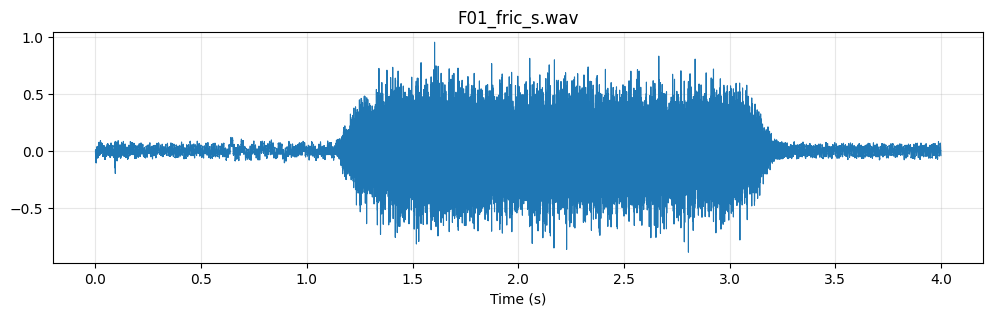

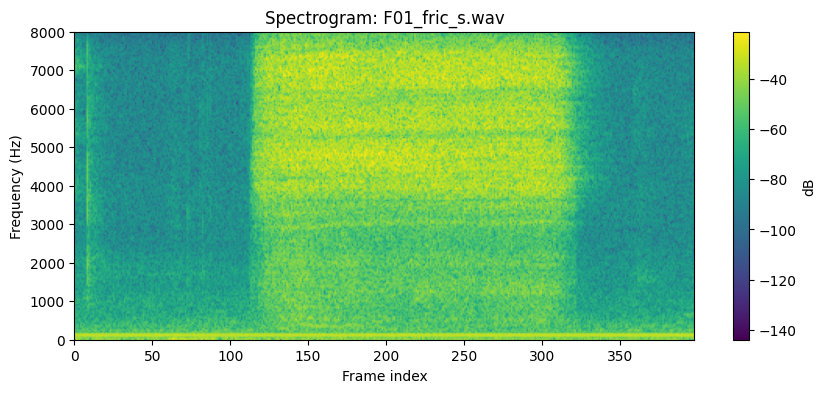

N (samples): 400 H (samples): 160
Frame duration: 0.025 sec | Hop: 0.01 sec


In [24]:
# Pick a clip index from the manifest list
CLIP_IDX = 6  # change me
clip = manifest["clips"][CLIP_IDX]
fs, x = read_wav(REC_DIR / clip["filename"])
x = peak_normalize(x)

# x = sig.lfilter([1, -PREEMPH_ALPHA], [1], x)
# x = peak_normalize(x)

play_audio(x, fs, f"Clip: {clip['filename']} ({clip['label']})")

# compute STFT (and return N,H that define frame grid)
N, H = plot_wave_and_spec(x, fs, clip["filename"], win_ms=25, hop_ms=10, nfft=1024)

len_x = len(x)  # used by helper above
print("N (samples):", N, "H (samples):", H)
print("Frame duration:", N/fs, "sec | Hop:", H/fs, "sec")


### 🔧 Practical audio conditioning (recommended)
Two small steps often make LPC envelopes cleaner:

1) **DC removal**: removes microphone offset  
2) **Pre-emphasis**: boosts high frequencies so the envelope is more balanced

You can toggle this on/off to see the effect.


In [21]:
USE_PREEMPH = True
PREEMPH_ALPHA = 0.97

if USE_PREEMPH:
    x = x - np.mean(x)
    x = sig.lfilter([1, -PREEMPH_ALPHA], [1], x)
    x = peak_normalize(x)
    print("Applied DC removal + pre-emphasis.")
else:
    print("Skipped pre-emphasis.")


Applied DC removal + pre-emphasis.


### 5B. Enter time ranges (seconds) for vowel / fricative / silence

Edit these based on the plots above.
You can add multiple ranges per category.


In [30]:
# مثال: choose time ranges based on your clip
# vowel_ranges = [(1.00, 2.00)]      # e.g., middle of vowel
# fricative_ranges = [(2.50, 3.20)]  # e.g., stable /s/ region
# silence_ranges = [(0.00, 0.50)]    # e.g., initial silence

vowel_ranges = [(1.5, 1.55)]      # e.g., middle of vowel
fricative_ranges = [(1.5, 1.6)]  # e.g., stable /s/ region
silence_ranges = [(0.00, 0.05)]    # e.g., initial silence

def ranges_to_frame_list(ranges, fs, N, H, len_x):
    max_i = 1 + (len_x - N) // H
    out = []
    for (t0,t1) in ranges:
        s0 = int(t0 * fs)
        s1 = int(t1 * fs)
        for i in range(max_i):
            c = i*H + N//2
            if s0 <= c <= s1:
                out.append(i)
    # unique + sorted
    out = sorted(list(set(out)))
    return out

VOWEL_FRAMES = ranges_to_frame_list(vowel_ranges, fs, N, H, len_x)
FRICATIVE_FRAMES = ranges_to_frame_list(fricative_ranges, fs, N, H, len_x)
SILENCE_FRAMES = ranges_to_frame_list(silence_ranges, fs, N, H, len_x)

print("VOWEL_FRAMES:", VOWEL_FRAMES[:20], "count=", len(VOWEL_FRAMES))
print("FRICATIVE_FRAMES:", FRICATIVE_FRAMES[:20], "count=", len(FRICATIVE_FRAMES))
print("SILENCE_FRAMES:", SILENCE_FRAMES[:20], "count=", len(SILENCE_FRAMES))


VOWEL_FRAMES: [149, 150, 151, 152, 153] count= 5
FRICATIVE_FRAMES: [149, 150, 151, 152, 153, 154, 155, 156, 157, 158] count= 10
SILENCE_FRAMES: [0, 1, 2, 3] count= 4


### 5C. Quick verification: plot a couple frames from each list

If the plotted frame is not what you intended, adjust the time ranges above.


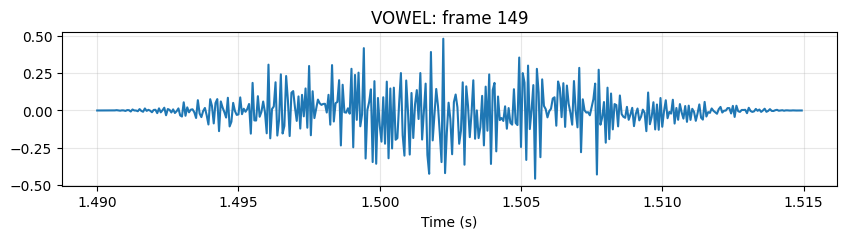

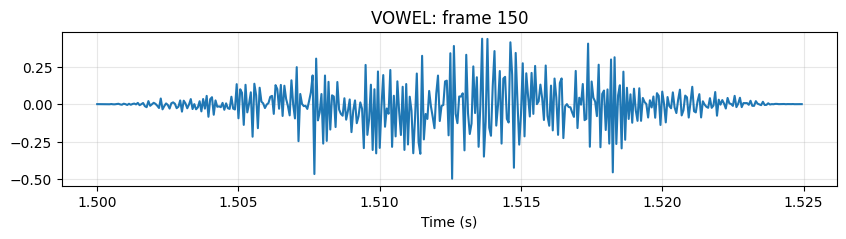

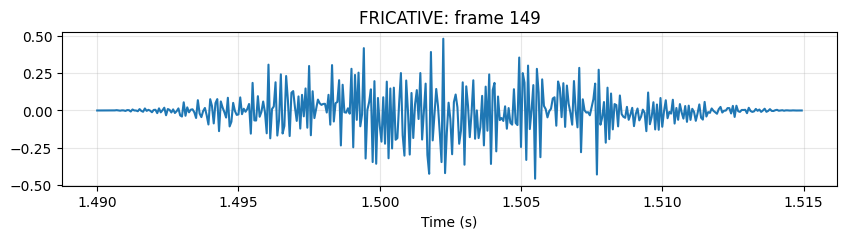

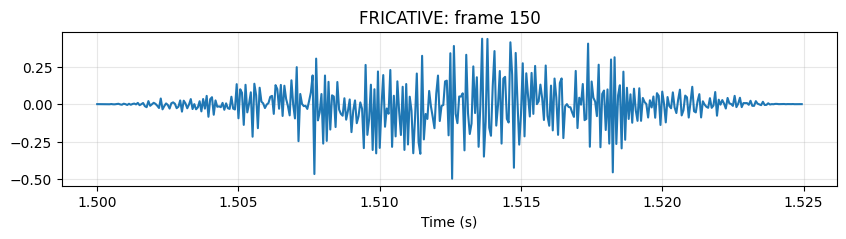

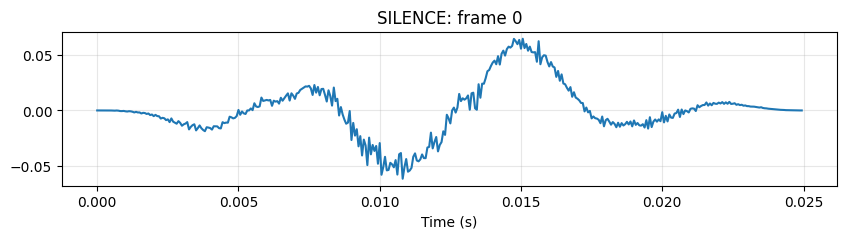

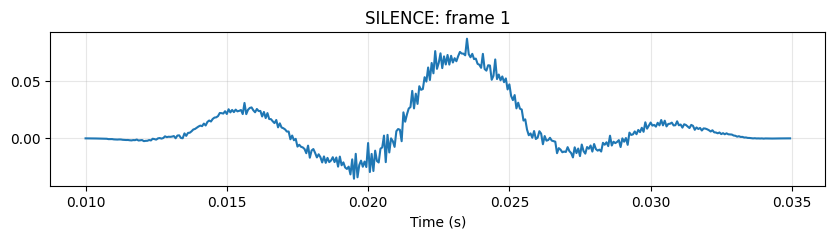

In [31]:
frames = frame_signal(x, N, H) * hann(N)[None,:]

def plot_frame(idx, label):
    xf = frames[idx]
    t = (np.arange(N) + idx*H)/fs
    plt.figure(figsize=(10,2))
    plt.plot(t, xf)
    plt.title(f"{label}: frame {idx}")
    plt.xlabel("Time (s)")
    plt.grid(True, alpha=0.3)
    plt.show()

for idx in VOWEL_FRAMES[:2]:
    plot_frame(idx, "VOWEL")
for idx in FRICATIVE_FRAMES[:2]:
    plot_frame(idx, "FRICATIVE")
for idx in SILENCE_FRAMES[:2]:
    plot_frame(idx, "SILENCE")


## 6. Save selections into manifest (so later notebooks run without questions)

This is the key “handoff” from Notebook 9.0 → 9.1–9.4.


In [27]:
# Persist for this clip
manifest = load_manifest()
for c in manifest["clips"]:
    if c["filename"] == clip["filename"]:
        c["frame_selections"] = {
            "win_ms": 25,
            "hop_ms": 10,
            "n_samples": int(N),
            "hop_samples": int(H),
            "vowel_frames": VOWEL_FRAMES,
            "fricative_frames": FRICATIVE_FRAMES,
            "silence_frames": SILENCE_FRAMES,
            "vowel_ranges": vowel_ranges,
            "fricative_ranges": fricative_ranges,
            "silence_ranges": silence_ranges
        }
save_manifest(manifest)
print("Saved frame selections into manifest for:", clip["filename"])


Saved frame selections into manifest for: F01_fric_s.wav


---
## ✅ What you learned (Notebook 9.0)
- You recorded (or loaded) a standard set of WAV files for Lecture 9
- You manually selected regions (time ranges → frames) for vowel/fricative/silence
- You saved selections in the manifest so later notebooks run smoothly

## ➡️ What’s next
Go to **Notebook 9.1** (LPC from scratch).


---
## 🧠 Reflection  (Notebook 9.0)

### What you learned
- How to create a repeatable recording dataset for speech processing experiments.
- Why manual frame selection matters for LPC (steady vowel middle vs transitions).
- How time ranges map to frame indices for short-time analysis.

### Common mistakes to notice (and fix next time)
- Selecting vowel frames near onset/offset (adds nonstationarity → unstable LPC).
- Using time ranges that include both vowel + consonant.
- Forgetting to save `frame_selections` to the manifest (later notebooks fail).

### Reflective questions 
1. Which clip was easiest to select vowel frames from, and why?
2. What visual cues in the spectrogram helped you decide vowel vs fricative vs silence?
3. If your vowel envelope looked “wrong” later, which selection mistake is most likely responsible?
4. How would you modify your recording procedure to make selection easier next time?

### Quick self-check (1 minute)
- [ ] I can explain why we choose the middle of a vowel.
- [ ] My manifest has `frame_selections` for at least one clip.
- [ ] I saved at least one figure (waveform or spectrogram).


### Answers

1. The vowel clip is only a vowel so it was the easiest.
2. The harmonics in the spectrogram helped.
3. It could be the duration of the frame.
4. I would try to get less background noise.